In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, advanced_activations
from keras import initializers, regularizers
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils.np_utils import to_categorical
# from keras.preprocessing.text import Tokenizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

random_seed = 123

In [8]:
pulsar_df = pd.read_csv('pulsar_stars.csv')
pulsar_df.head(10)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,0
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,0
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,0
9,107.257812,39.496488,0.465882,1.162877,4.079431,24.980418,7.397080,57.784738,0


In [9]:
X = pulsar_df.drop('target_class', axis=1)
y = pulsar_df['target_class']
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(12528, 8) (5370, 8)
(12528,) (5370,)


# Classifier

In [10]:
def grid_search_classifier(clf, param_grid, X_train, X_test, y_train, y_test, scoring='f1_weighted'):
    grid_clf = GridSearchCV(clf, param_grid, scoring=scoring, n_jobs = -1)
    grid_clf.fit(X_train, y_train)

    best_parameters = grid_clf.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    y_pred = grid_clf.predict(X_test)

    print()
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('Accuracy score:', round(accuracy_score(y_test, y_pred), 4))

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens')
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()
    return grid_clf

# Random Forest 

In [11]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_features': [2, 5, 8],
              'n_estimators': [10, 25, 50, 100, 250]
             }

/Users/bridget/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
max_depth: 10
max_features: 5
n_estimators: 25

[[4818   42]
 [  74  436]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4860
           1       0.91      0.85      0.88       510

   micro avg       0.98      0.98      0.98      5370
   macro avg       0.95      0.92      0.94      5370
weighted avg       0.98      0.98      0.98      5370

Accuracy score: 0.9784


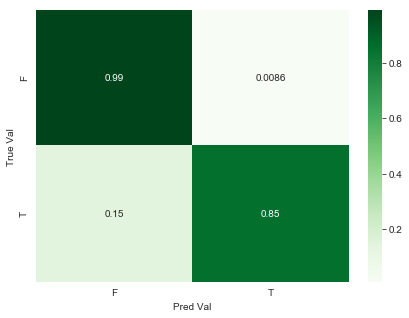

In [12]:
rf_grid_clf = grid_search_classifier(RandomForestClassifier(), param_grid, X_train, X_test, y_train, y_test)

In [61]:
best_rf = RandomForestClassifier(n_estimators = 250, max_depth = 10, max_features =5, random_state = random_seed)
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)

# KNN

In [62]:
knn_param_grid = {'n_neighbors': [7, 9, 11, 13], 
             'weights': ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan']}

/Users/bridget/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
metric: 'manhattan'
n_neighbors: 13
weights: 'uniform'

[[4822   38]
 [ 121  389]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4860
           1       0.91      0.76      0.83       510

   micro avg       0.97      0.97      0.97      5370
   macro avg       0.94      0.88      0.91      5370
weighted avg       0.97      0.97      0.97      5370

Accuracy score: 0.9704


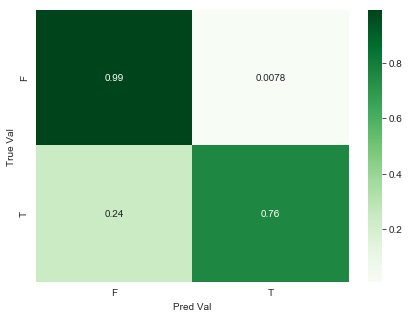

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [63]:
grid_search_classifier(KNeighborsClassifier(), knn_param_grid, X_train, X_test, y_train, y_test, scoring='f1_weighted')

In [ ]:
best_knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 11, weights: 'distance')
knn_pred = best_knn.predict(X_test)

# SVM

In [39]:
# svm_param_grid = {'kernel': ('poly', 'sigmoid', 'rbf'),
#                   'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),
#                   'decision_function_shape':('ovo','ovr'),
#                   'shrinking':(True,False)}

In [43]:
# grid_search_classifier(SVC(), svm_param_grid, X_train, X_test, y_train, y_test, scoring='f1_weighted')

/Users/bridget/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
# best_svm = SVC()
# svm_pred = .pred(X_test)

# Neural Network 

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)
print(y_train_cat.shape, y_test_cat.shape)

In [ ]:
def neural_net_accuracy(fit_model, train_x, val_x, train_y, val_y):
    y_pred = fit_model.predict(val_x)
    
    pred_train = fit_model.predict(train_x).reshape(-1)
    pred_val = y_pred.reshape(-1)  

    MSE_train = np.mean((pred_train-train_y)**2)
    MSE_val = np.mean((pred_val-val_y)**2)

    print("MSE_train:", MSE_train)
    print("MSE_val:", MSE_val)
    
    print()
    
    print(confusion_matrix(train_y, y_pred))
    print(classification_report(val_y, y_pred))
    print('Accuracy score:', round(accuracy_score(val_y, y_pred), 2))

    cm = confusion_matrix(val_y, y_pred)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens')
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [ ]:
model = Sequential()
model.add(Dense(2, activation = 'sigmoid'))

model.compile(optimizer= "sgd", loss='mse', metrics=['acc'])
fit_model = model.fit(X_train, y_train_cat, batch_size=32, epochs=10, validation_data=(X_val, y_val_cat))

In [ ]:
model.add(Dense(100))
model.add(advanced_activations.LeakyReLU(alpha=0.2))
model.add(Dense(2, activation = 'sigmoid'))


model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['acc'])
fit_model = model.fit(X_train, y_train_cat, batch_size=32, epochs=50, 
                      validation_data=(X_test, y_test_cat))